In [ ]:
!pip install livelossplot
!pip install imageio-ffmpeg

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Periodic Position Encoding
class PeriodicEncoding(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(PeriodicEncoding, self).__init__()
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.freqs = torch.tensor([2**i for i in range(encoding_dim)], dtype=torch.float32)

    def forward(self, x):
        # Generate sine and cosine encodings
        encodings = [x]
        for freq in self.freqs:
            encodings.append(torch.sin(freq * x))
            encodings.append(torch.cos(freq * x))
        return torch.cat(encodings, dim=-1)

# Define the MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, use_pe=False, pe_dim=0):
        super(MLP, self).__init__()
        self.use_pe = use_pe
        if use_pe:
            self.pe = PeriodicEncoding(input_dim, pe_dim)
            input_dim = input_dim + 2 * pe_dim * input_dim
        self.layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim)] +
                                    [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)] +
                                    [nn.Linear(hidden_dim, output_dim)])
        self.activation = nn.Sigmoid()

    def forward(self, x):
        if self.use_pe:
            x = self.pe(x)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

# Generate synthetic 2D image fitting data
def generate_data(num_points=5000):
    x = np.random.uniform(-1, 1, size=(num_points, 2))
    y = (np.sin(5 * x[:, 0]) * np.cos(5 * x[:, 1])).reshape(-1, 1)  # Generate a complex pattern
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Train the MLP
def train(model, criterion, optimizer, data, epochs=200):
    x, y = data
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    return model

# Visualize neurons in input space
def visualize_activations(model, grid_size=100, title=""):
    xx, yy = torch.meshgrid(
        torch.linspace(-1, 1, grid_size), torch.linspace(-1, 1, grid_size)
    )
    grid = torch.stack([xx.flatten(), yy.flatten()], dim=-1)
    activations = model(grid).detach().numpy()

    fig, ax = plt.subplots(figsize=(8, 6))
    for i in range(activations.shape[1]):
        ax.contourf(xx, yy, activations[:, i].reshape(grid_size, grid_size), alpha=0.5, levels=10)
    plt.title(title)
    plt.xlabel("Input Dimension 1")
    plt.ylabel("Input Dimension 2")
    plt.show()

# Experiment parameters
input_dim = 2
hidden_dim = 10
output_dim = 1
num_layers = 5
pe_dim = 5

In [ ]:
# Generate data
# data = generate_data()

# Train MLP without PE
model_no_pe = MLP(input_dim, hidden_dim, output_dim, num_layers, use_pe=False)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model_no_pe.parameters(), lr=0.01)
# model_no_pe = train(model_no_pe, criterion, optimizer, data, epochs=200)

# Train MLP with PE
model_pe = MLP(input_dim, hidden_dim, output_dim, num_layers, use_pe=True, pe_dim=pe_dim)
# optimizer = optim.Adam(model_pe.parameters(), lr=0.01)
# model_pe = train(model_pe, criterion, optimizer, data, epochs=200)

# # Visualize activations
# visualize_activations(model_no_pe, title="Neuron Activations Without PE")
# visualize_activations(model_pe, title="Neuron Activations With PE")

In [ ]:

img = plt.imread('/content/Exoplanet_sphere.jpg').mean(-1)

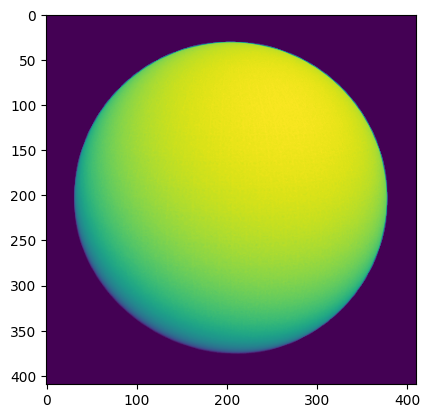

In [ ]:
plt.imshow(img)

In [ ]:
#@title Hepler Functions and Imports
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch

import time
from livelossplot import PlotLosses
import copy
import tqdm
import sys

In [ ]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler=None,
                num_epochs=25, save_checkpoints=None, return_best_val=False, checkpoint_path=None):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()
    liveloss = PlotLosses()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                continue
                # model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i,inputs in enumerate(dataloaders):
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    # Convert input tensor to float32
                    outputs = model(inputs[...,:-1].type(torch.float32))
                    loss = criterion(outputs, inputs[...,-1:].type(torch.float32))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler is not None:
                            scheduler.step(loss)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(dataloaders), loss.item() * inputs.size(0)), end="")

                sys.stdout.flush()


            epoch_loss = running_loss / dataset_sizes
            if phase == 'train':
                avg_loss = epoch_loss
                val_loss = epoch_loss


            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

            if save_checkpoints is not None and phase== 'val':
                if epoch in save_checkpoints:
                    save_model = copy.deepcopy(model)
                    torch.save(save_model,f'{checkpoint_path}_{epoch}_{epoch_loss:.3f}_{val_loss:.3f}.pt')


        liveloss.update({
            'log loss': avg_loss,
        })

        liveloss.draw()
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, 0))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    if return_best_val:
        model.load_state_dict(best_model_wts)

    return model

def get_mgrid(sidelen):

    # Generate 2D pixel coordinates from an image of sidelen x sidelen
    pixel_coords = np.stack(np.mgrid[:sidelen,:sidelen], axis=-1)[None,...].astype(np.float32)
    pixel_coords /= sidelen
    pixel_coords -= 0.5
    pixel_coords = torch.Tensor(pixel_coords).view(-1, 2)
    return pixel_coords

In [ ]:
sidelen = img.shape[0]
x = get_mgrid(sidelen)
y = torch.tensor(img.reshape(-1,1))
inputs = torch.hstack([x,y])

dataloader = torch.utils.data.DataLoader(inputs,
                                         batch_size=128,
                                         pin_memory=True,
                                         shuffle=True)

In [ ]:
optimizer = torch.optim.Adam(model_no_pe.parameters(),lr=1e-3)

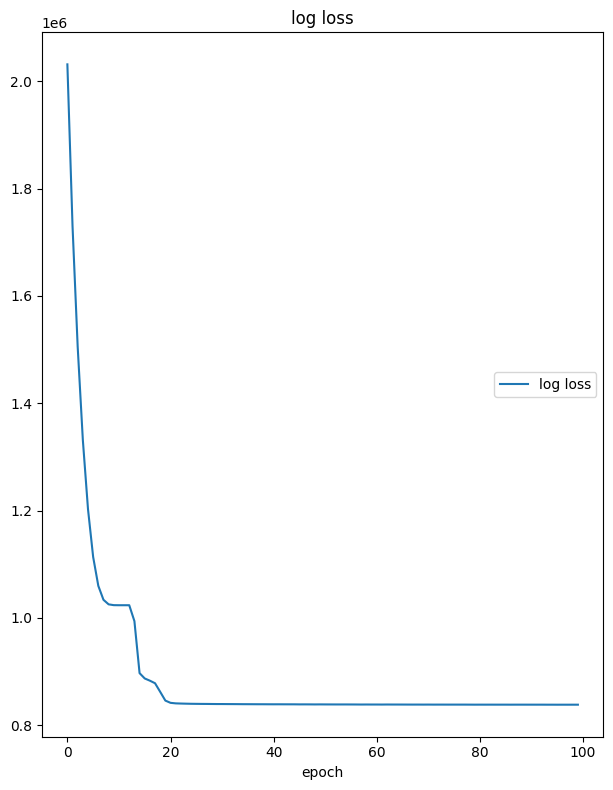

log loss
	log loss         	 (min: 838282.071, max: 2031423.956, cur: 838312.846)
Train Loss: 838312.8457 Acc: 0.0000

Training complete in 20m 28s


In [ ]:
criterion = torch.nn.MSELoss()

model_no_pe = train_model(model_no_pe,optimizer=optimizer,
            dataloaders=dataloader,
            criterion=criterion,
            dataset_sizes=len(dataloader),
            num_epochs=100,
           )

In [ ]:
torch.save(model_no_pe.state_dict(), 'inr_sigmoid_model_no_pe_weights.pth')

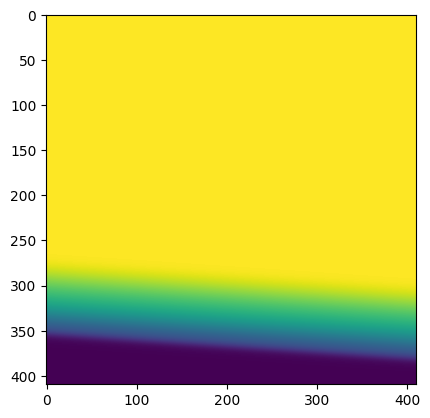

In [ ]:
with torch.no_grad():
    plt.imshow(model_no_pe.forward(x).reshape(sidelen,sidelen).cpu().numpy())

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def fn(out_pre,model_dict_ls,li):
    if li == len(model_dict_ls)/2:
        return out_pre
    out_cur = []
    for i in range(len(model_dict_ls[2*li])):
        x = 0
        for j in range(len(out_pre)):
            x = x + out_pre[j]*model_dict_ls[2*li][i][j]
        if li == (len(model_dict_ls)/2)-1:
            out_cur.append(x+model_dict_ls[2*li+1][i])
        else:
            out_cur.append(sigmoid(x+model_dict_ls[2*li+1][i]))
    li+=1
    return fn(np.array(out_cur),model_dict_ls,li)

In [ ]:


model_no_pe.load_state_dict(torch.load('/content/inr_sigmoid_model_no_pe_weights.pth'))

<ipython-input-12-c9befc74d8c7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_no_pe.load_state_dict(torch.load('/content/inr_sigmoid_model_no_pe_weights.pth'))


<All keys matched successfully>

Accuracy: 0.0


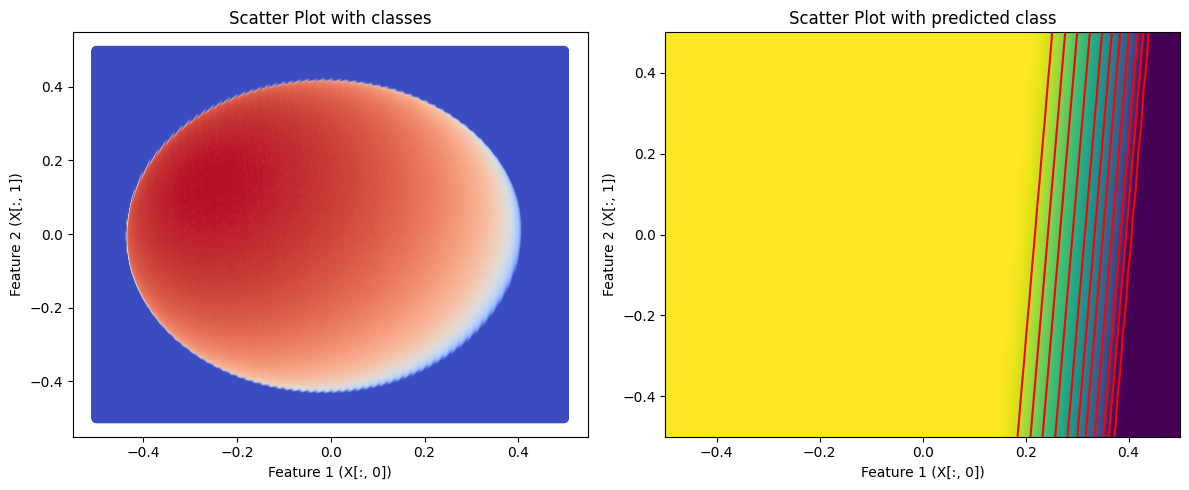

In [ ]:
X3 = dataloader.__dict__['dataset'][:,:-1]
c = dataloader.__dict__['dataset'][:,-1].numpy()
y3 = dataloader.__dict__['dataset'][:,-1].numpy()

X3_tensor = X3#torch.from_numpy(X3).float()

# Make predictions
with torch.no_grad():
    predicted = model_no_pe(X3_tensor.float()).cpu().numpy()
    #predictions = (predicted > 0.5).astype(int)
    predictions = predicted.flatten()

# Calculate the accuracy
accuracy = np.mean(predictions == y3)
print("Accuracy:", accuracy)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))



#plt.xlim([domain[0][0],domain[2][0]])
#plt.ylim([domain[0][1],domain[2][1]])

# Plot the color-coded classification
ax1.scatter(X3[:, 0], X3[:, 1], c=y3, cmap='coolwarm')
ax1.set_xlabel('Feature 1 (X[:, 0])')
ax1.set_ylabel('Feature 2 (X[:, 1])')
ax1.set_title('Scatter Plot with classes')

domain = torch.tensor([
    [-.5,-.5],
    [-.5,.5],
    [.5,.5],
    [.5,-.5],
    [-.5,-.5]
])

# Plot the second graph (Scatter Plot with predicted class)
ax2.scatter(X3[:, 0], X3[:, 1], c=predictions, cmap='viridis')
x2 = np.linspace(domain[0][0],domain[2][0], 100)
y2 = np.linspace(domain[0][1],domain[2][1], 100)
X2, Y2 = np.meshgrid(x2, y2)
#Z2 = (model2.fc2.weight.data[0][0]*(1/(1+np.exp((-model2.fc1.weight.data[0][0])* X2 - model2.fc1.weight.data[0][1]* Y2 - model2.fc1.bias.data[0])))) +(model2.fc2.weight.data[0][1]*(1/(1+ np.exp(-model2.fc1.weight.data[1][0] * X2 - model2.fc1.weight.data[1][1]*Y2 - model2.fc1.bias.data[1])))) +model2.fc2.bias.data[0]
model_dict_ls = [np.array(ls.cpu()) for ls in list(model_no_pe.state_dict().values())]
Z = fn(np.array([X2,Y2]),model_dict_ls,0)[0]
# Plot the equation as a contour line
plt.contour(X2, Y2, Z, levels=[0,1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230], colors='red')
ax2.set_xlabel('Feature 1 (X[:, 0])')
ax2.set_ylabel('Feature 2 (X[:, 1])')
ax2.set_title('Scatter Plot with predicted class')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [ ]:
optimizer = torch.optim.Adam(model_pe.parameters(),lr=1e-3)

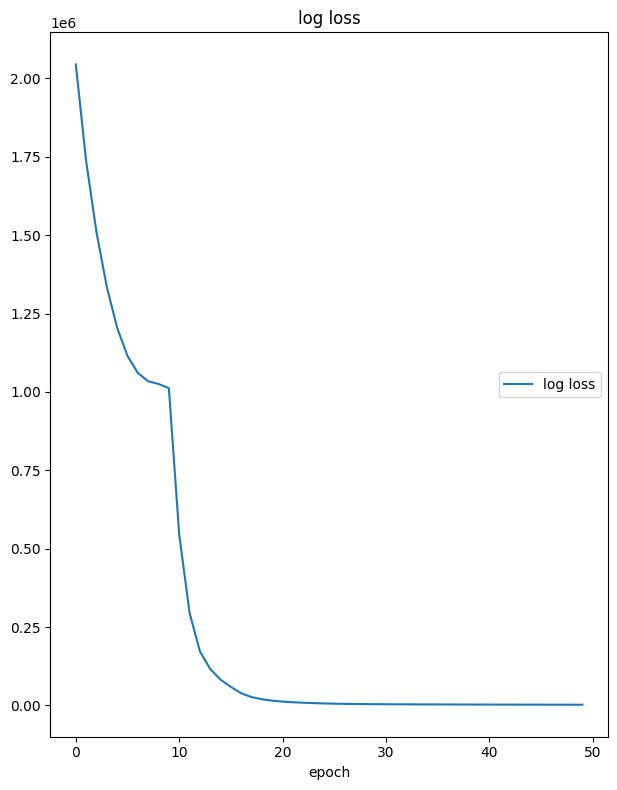

log loss
	log loss         	 (min: 2305.457, max: 2044964.998, cur: 2305.457)
Train Loss: 2305.4567 Acc: 0.0000

Training complete in 10m 24s


In [ ]:
criterion = torch.nn.MSELoss()

model_pe = train_model(model_pe,optimizer=optimizer,
            dataloaders=dataloader,
            criterion=criterion,
            dataset_sizes=len(dataloader),
            num_epochs=50,
           )

In [ ]:
torch.save(model_pe.state_dict(), 'inr_sigmoid_model_pe_weights.pth')

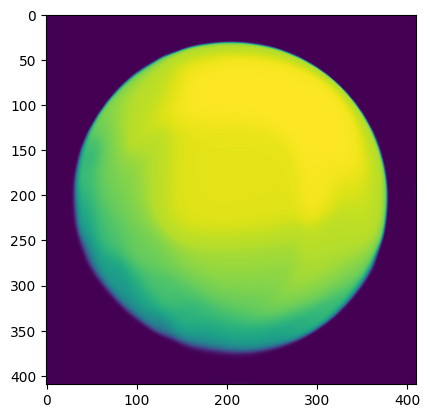

In [ ]:
with torch.no_grad():
    plt.imshow(model_pe.forward(x).reshape(sidelen,sidelen).cpu().numpy())

In [ ]:
# prompt: function to generate encoded input

def generate_encoded_input(model, input_data):
  """Generates encoded input using the given model.

  Args:
    model: The MLP model.
    input_data: The input data.

  Returns:
    The encoded input.
  """
  with torch.no_grad():
    encoded_input = model.pe(input_data) if model.use_pe else input_data
    return encoded_input

# Example usage:
# Assuming you have an input tensor 'input_tensor' and a trained model 'model_pe'
# encoded_input = generate_encoded_input(model_pe, input_tensor)

In [ ]:
model_pe.load_state_dict(torch.load('/content/inr_sigmoid_model_pe_weights.pth'))

<ipython-input-16-d3d3d7de6c0e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_pe.load_state_dict(torch.load('/content/inr_sigmoid_model_pe_weights.pth'))


<All keys matched successfully>

Accuracy: 0.0


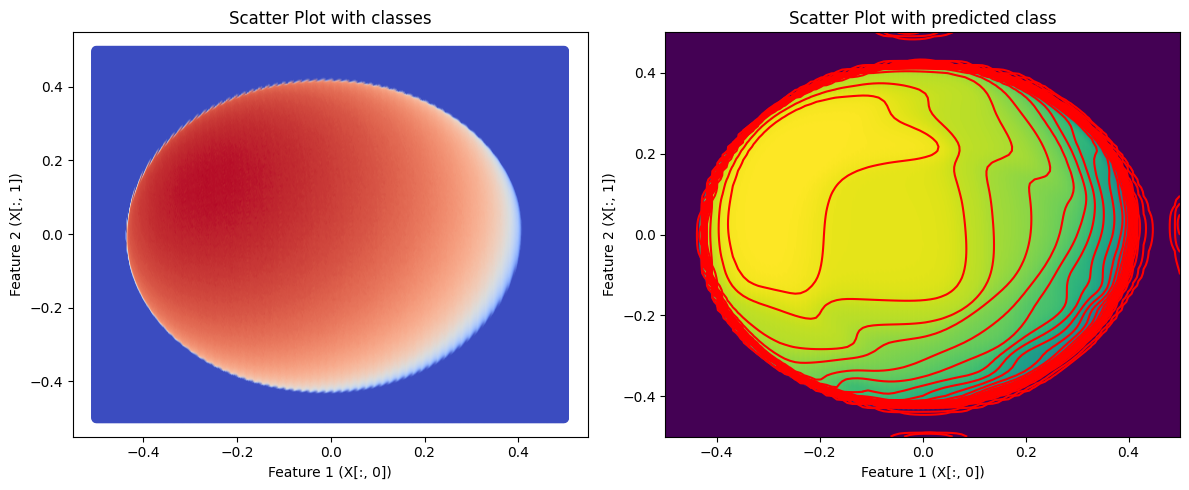

In [ ]:
X3 = dataloader.__dict__['dataset'][:,:-1]
c = dataloader.__dict__['dataset'][:,-1].numpy()
y3 = dataloader.__dict__['dataset'][:,-1].numpy()

X3_tensor = X3#torch.from_numpy(X3).float()

# Make predictions
with torch.no_grad():
    predicted = model_pe(X3_tensor.float()).cpu().numpy()
    #predictions = (predicted > 0.5).astype(int)
    predictions = predicted.flatten()

# Calculate the accuracy
accuracy = np.mean(predictions == y3)
print("Accuracy:", accuracy)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))



#plt.xlim([domain[0][0],domain[2][0]])
#plt.ylim([domain[0][1],domain[2][1]])

# Plot the color-coded classification
ax1.scatter(X3[:, 0], X3[:, 1], c=y3, cmap='coolwarm')
ax1.set_xlabel('Feature 1 (X[:, 0])')
ax1.set_ylabel('Feature 2 (X[:, 1])')
ax1.set_title('Scatter Plot with classes')

domain = torch.tensor([
    [-.5,-.5],
    [-.5,.5],
    [.5,.5],
    [.5,-.5],
    [-.5,-.5]
])

# Plot the second graph (Scatter Plot with predicted class)
ax2.scatter(X3[:, 0], X3[:, 1], c=predictions, cmap='viridis')
x2 = np.linspace(domain[0][0],domain[2][0], 100)
y2 = np.linspace(domain[0][1],domain[2][1], 100)
X2, Y2 = np.meshgrid(x2, y2)
#Z2 = (model2.fc2.weight.data[0][0]*(1/(1+np.exp((-model2.fc1.weight.data[0][0])* X2 - model2.fc1.weight.data[0][1]* Y2 - model2.fc1.bias.data[0])))) +(model2.fc2.weight.data[0][1]*(1/(1+ np.exp(-model2.fc1.weight.data[1][0] * X2 - model2.fc1.weight.data[1][1]*Y2 - model2.fc1.bias.data[1])))) +model2.fc2.bias.data[0]
model_dict_ls = [np.array(ls.cpu()) for ls in list(model_pe.state_dict().values())]
#encoded = generate_encoded_input(model_pe, torch.tensor([X2,Y2]).float())
encoding_dim = 5
freqs = [2**i for i in range(encoding_dim)]
encodings = [X2,Y2]
for freq in freqs:
    encodings.append(np.sin(freq * X2))
    encodings.append(np.sin(freq * Y2))
    encodings.append(np.cos(freq * X2))
    encodings.append(np.cos(freq * Y2))
Z = fn(np.array(encodings),model_dict_ls,0)[0]
# Plot the equation as a contour line
plt.contour(X2, Y2, Z, levels=[0,1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230], colors='red')
ax2.set_xlabel('Feature 1 (X[:, 0])')
ax2.set_ylabel('Feature 2 (X[:, 1])')
ax2.set_title('Scatter Plot with predicted class')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# With SiLU

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Periodic Position Encoding
class PeriodicEncoding(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(PeriodicEncoding, self).__init__()
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.freqs = torch.tensor([2**i for i in range(encoding_dim)], dtype=torch.float32)

    def forward(self, x):
        # Generate sine and cosine encodings
        encodings = [x]
        for freq in self.freqs:
            encodings.append(torch.sin(freq * x))
            encodings.append(torch.cos(freq * x))
        return torch.cat(encodings, dim=-1)

# Define the MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, use_pe=False, pe_dim=0):
        super(MLP, self).__init__()
        self.use_pe = use_pe
        if use_pe:
            self.pe = PeriodicEncoding(input_dim, pe_dim)
            input_dim = input_dim + 2 * pe_dim * input_dim
        self.layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim)] +
                                    [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)] +
                                    [nn.Linear(hidden_dim, output_dim)])
        self.activation = nn.SiLU()

    def forward(self, x):
        if self.use_pe:
            x = self.pe(x)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

In [ ]:
# Generate data
# data = generate_data()

# Train MLP without PE
model_s_no_pe = MLP(input_dim, hidden_dim, output_dim, num_layers, use_pe=False)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model_no_pe.parameters(), lr=0.01)
# model_no_pe = train(model_no_pe, criterion, optimizer, data, epochs=200)

# Train MLP with PE
model_s_pe = MLP(input_dim, hidden_dim, output_dim, num_layers, use_pe=True, pe_dim=pe_dim)
# optimizer = optim.Adam(model_pe.parameters(), lr=0.01)
# model_pe = train(model_pe, criterion, optimizer, data, epochs=200)

# # Visualize activations
# visualize_activations(model_no_pe, title="Neuron Activations Without PE")
# visualize_activations(model_pe, title="Neuron Activations With PE")

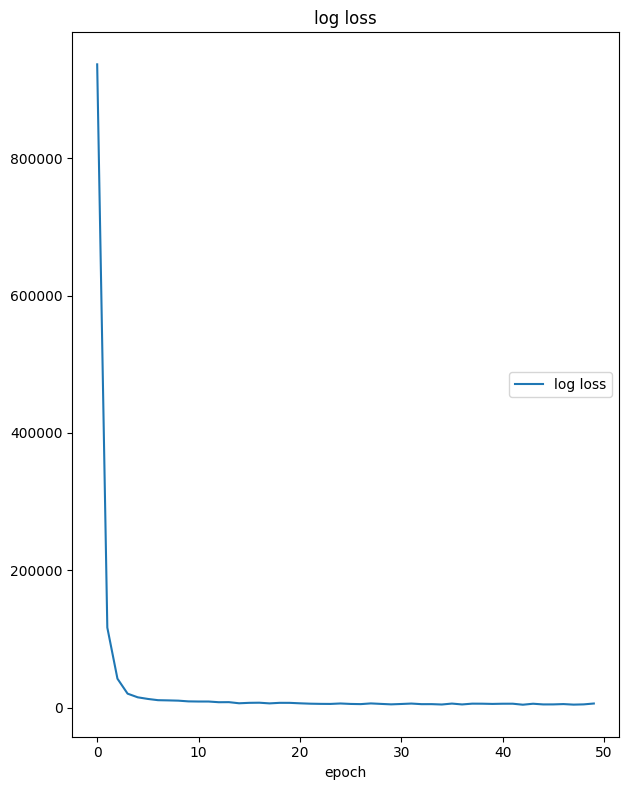

log loss
	log loss         	 (min: 4078.148, max: 937083.403, cur: 5808.925)
Train Loss: 5808.9247 Acc: 0.0000

Training complete in 10m 13s


In [ ]:
optimizer = torch.optim.Adam(model_s_no_pe.parameters(),lr=1e-3)

criterion = torch.nn.MSELoss()

model_s_no_pe = train_model(model_s_no_pe,optimizer=optimizer,
            dataloaders=dataloader,
            criterion=criterion,
            dataset_sizes=len(dataloader),
            num_epochs=50,
           )

In [ ]:
torch.save(model_s_no_pe.state_dict(), 'inr_siLU_model_no_pe_weights.pth')

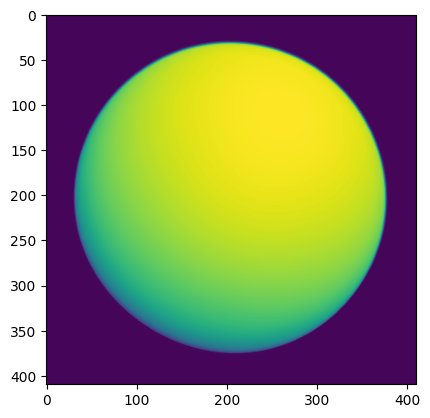

In [ ]:
with torch.no_grad():
    plt.imshow(model_s_no_pe.forward(x).reshape(sidelen,sidelen).cpu().numpy())

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def fn(out_pre,model_dict_ls,li):
    if li == len(model_dict_ls)/2:
        return out_pre
    out_cur = []
    for i in range(len(model_dict_ls[2*li])):
        x = 0
        for j in range(len(out_pre)):
            x = x + out_pre[j]*model_dict_ls[2*li][i][j]
        if li == (len(model_dict_ls)/2)-1:
            out_cur.append(((x+model_dict_ls[2*li+1][i])*sigmoid(x+model_dict_ls[2*li+1][i])))
        else:
            out_cur.append((x+model_dict_ls[2*li+1][i])*sigmoid(x+model_dict_ls[2*li+1][i]))
    li+=1
    return fn(np.array(out_cur),model_dict_ls,li)

In [ ]:
model_s_no_pe.load_state_dict(torch.load('/content/inr_siLU_model_no_pe_weights.pth'))

<ipython-input-21-55a8227a5ef2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_s_no_pe.load_state_dict(torch.load('/content/inr_siLU_model_no_pe_weights.pth'))


<All keys matched successfully>

Accuracy: 0.0


<ipython-input-20-9c9a21c92f84>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


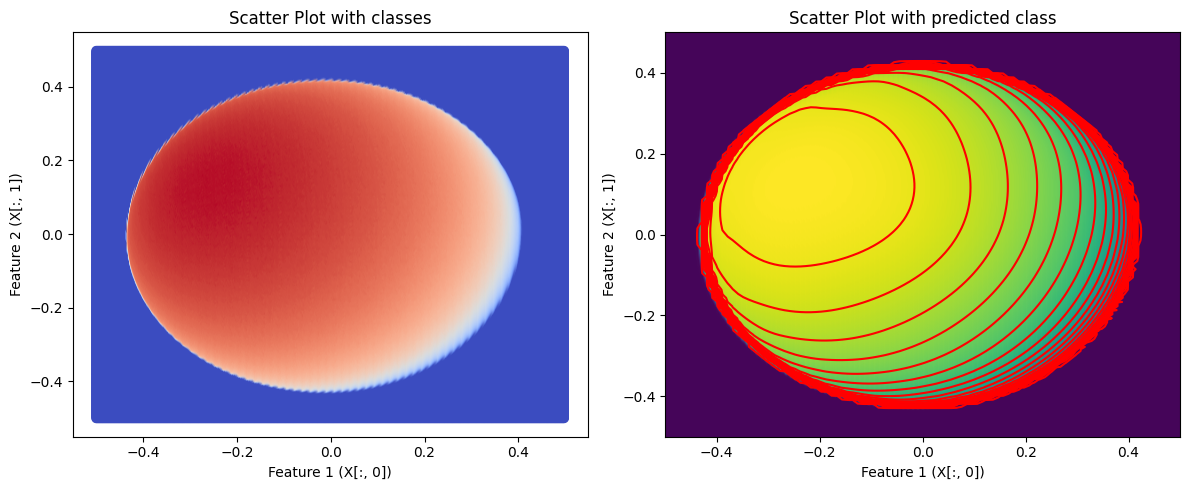

In [ ]:
X3 = dataloader.__dict__['dataset'][:,:-1]
c = dataloader.__dict__['dataset'][:,-1].numpy()
y3 = dataloader.__dict__['dataset'][:,-1].numpy()

X3_tensor = X3#torch.from_numpy(X3).float()

# Make predictions
with torch.no_grad():
    predicted = model_s_no_pe(X3_tensor.float()).cpu().numpy()
    #predictions = (predicted > 0.5).astype(int)
    predictions = predicted.flatten()

# Calculate the accuracy
accuracy = np.mean(predictions == y3)
print("Accuracy:", accuracy)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))



#plt.xlim([domain[0][0],domain[2][0]])
#plt.ylim([domain[0][1],domain[2][1]])

# Plot the color-coded classification
ax1.scatter(X3[:, 0], X3[:, 1], c=y3, cmap='coolwarm')
ax1.set_xlabel('Feature 1 (X[:, 0])')
ax1.set_ylabel('Feature 2 (X[:, 1])')
ax1.set_title('Scatter Plot with classes')

domain = torch.tensor([
    [-.5,-.5],
    [-.5,.5],
    [.5,.5],
    [.5,-.5],
    [-.5,-.5]
])

# Plot the second graph (Scatter Plot with predicted class)
ax2.scatter(X3[:, 0], X3[:, 1], c=predictions, cmap='viridis')
x2 = np.linspace(domain[0][0],domain[2][0], 100)
y2 = np.linspace(domain[0][1],domain[2][1], 100)
X2, Y2 = np.meshgrid(x2, y2)
#Z2 = (model2.fc2.weight.data[0][0]*(1/(1+np.exp((-model2.fc1.weight.data[0][0])* X2 - model2.fc1.weight.data[0][1]* Y2 - model2.fc1.bias.data[0])))) +(model2.fc2.weight.data[0][1]*(1/(1+ np.exp(-model2.fc1.weight.data[1][0] * X2 - model2.fc1.weight.data[1][1]*Y2 - model2.fc1.bias.data[1])))) +model2.fc2.bias.data[0]
model_dict_ls = [np.array(ls.cpu()) for ls in list(model_s_no_pe.state_dict().values())]
Z = fn(np.array([X2,Y2]),model_dict_ls,0)[0]
# Plot the equation as a contour line
plt.contour(X2, Y2, Z, levels=[0,1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230], colors='red')
ax2.set_xlabel('Feature 1 (X[:, 0])')
ax2.set_ylabel('Feature 2 (X[:, 1])')
ax2.set_title('Scatter Plot with predicted class')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [ ]:
optimizer = torch.optim.Adam(model_s_pe.parameters(),lr=1e-3)

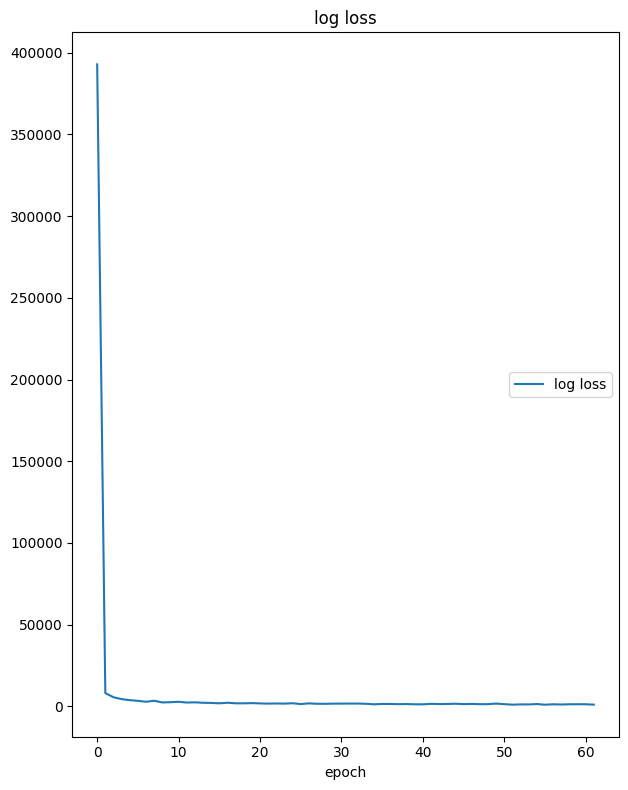

log loss
	log loss         	 (min:  987.131, max: 392865.454, cur: 1016.831)
Train Loss: 1016.8307 Acc: 0.0000

Iteration: 1178/1314, Loss: 270.1878662109375.

KeyboardInterrupt: 

In [ ]:
criterion = torch.nn.MSELoss()

model_s_pe = train_model(model_s_pe,optimizer=optimizer,
            dataloaders=dataloader,
            criterion=criterion,
            dataset_sizes=len(dataloader),
            num_epochs=100,
           )

In [ ]:
torch.save(model_s_pe.state_dict(), 'inr_siLU_model_pe_weights.pth')

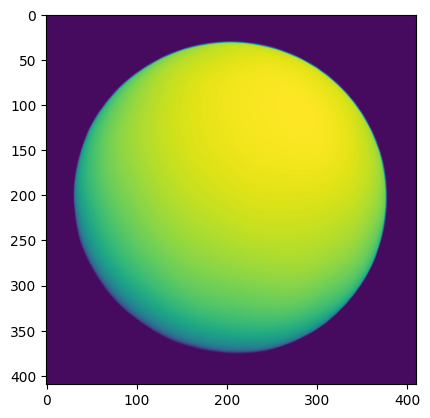

In [ ]:
with torch.no_grad():
    plt.imshow(model_s_pe.forward(x).reshape(sidelen,sidelen).cpu().numpy())

In [ ]:
model_s_pe.load_state_dict(torch.load('/content/inr_siLU_model_pe_weights.pth'))

<ipython-input-23-3a2a0650e01c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_s_pe.load_state_dict(torch.load('/content/inr_siLU_model_pe_weights.pth'))


<All keys matched successfully>

Accuracy: 0.0


<ipython-input-20-9c9a21c92f84>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


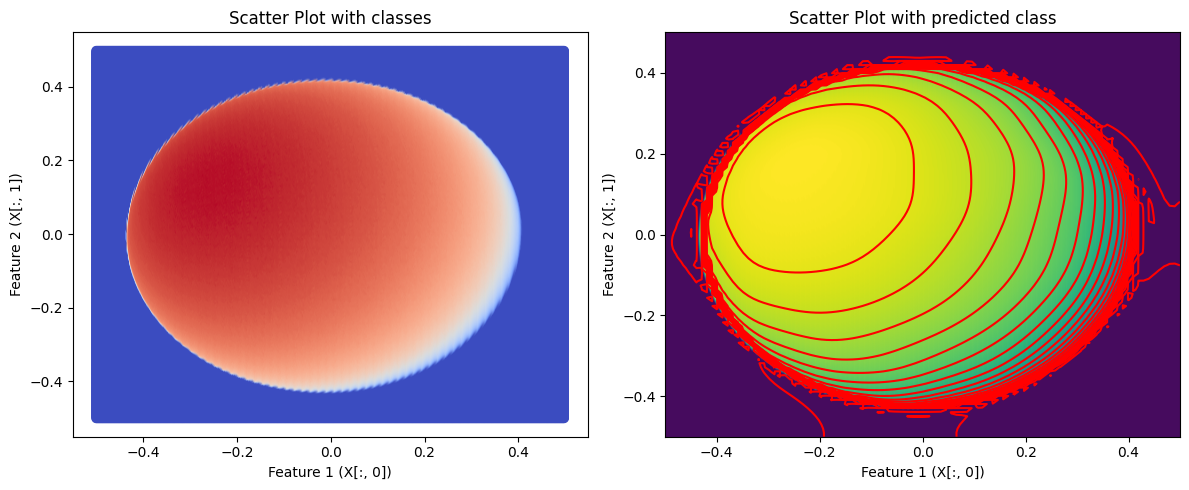

In [ ]:
X3 = dataloader.__dict__['dataset'][:,:-1]
c = dataloader.__dict__['dataset'][:,-1].numpy()
y3 = dataloader.__dict__['dataset'][:,-1].numpy()

X3_tensor = X3#torch.from_numpy(X3).float()

# Make predictions
with torch.no_grad():
    predicted = model_s_pe(X3_tensor.float()).cpu().numpy()
    #predictions = (predicted > 0.5).astype(int)
    predictions = predicted.flatten()

# Calculate the accuracy
accuracy = np.mean(predictions == y3)
print("Accuracy:", accuracy)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))



#plt.xlim([domain[0][0],domain[2][0]])
#plt.ylim([domain[0][1],domain[2][1]])

# Plot the color-coded classification
ax1.scatter(X3[:, 0], X3[:, 1], c=y3, cmap='coolwarm')
ax1.set_xlabel('Feature 1 (X[:, 0])')
ax1.set_ylabel('Feature 2 (X[:, 1])')
ax1.set_title('Scatter Plot with classes')

domain = torch.tensor([
    [-.5,-.5],
    [-.5,.5],
    [.5,.5],
    [.5,-.5],
    [-.5,-.5]
])

# Plot the second graph (Scatter Plot with predicted class)
ax2.scatter(X3[:, 0], X3[:, 1], c=predictions, cmap='viridis')
x2 = np.linspace(domain[0][0],domain[2][0], 100)
y2 = np.linspace(domain[0][1],domain[2][1], 100)
X2, Y2 = np.meshgrid(x2, y2)
#Z2 = (model2.fc2.weight.data[0][0]*(1/(1+np.exp((-model2.fc1.weight.data[0][0])* X2 - model2.fc1.weight.data[0][1]* Y2 - model2.fc1.bias.data[0])))) +(model2.fc2.weight.data[0][1]*(1/(1+ np.exp(-model2.fc1.weight.data[1][0] * X2 - model2.fc1.weight.data[1][1]*Y2 - model2.fc1.bias.data[1])))) +model2.fc2.bias.data[0]
model_dict_ls = [np.array(ls.cpu()) for ls in list(model_s_pe.state_dict().values())]
encoding_dim = 5
freqs = [2**i for i in range(encoding_dim)]
encodings = [X2,Y2]
for freq in freqs:
    encodings.append(np.sin(freq * X2))
    encodings.append(np.sin(freq * Y2))
    encodings.append(np.cos(freq * X2))
    encodings.append(np.cos(freq * Y2))
Z = fn(np.array(encodings),model_dict_ls,0)[0]
# Plot the equation as a contour line
plt.contour(X2, Y2, Z, levels=[0,1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230], colors='red')
ax2.set_xlabel('Feature 1 (X[:, 0])')
ax2.set_ylabel('Feature 2 (X[:, 1])')
ax2.set_title('Scatter Plot with predicted class')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()